In [1]:
import os
import datetime

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib.pylab import plt
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

cwd = os.getcwd()
data = pd.read_csv(os.path.join('../data/rides/')+'transported_hour_data.csv', usecols=[0,1,2], parse_dates = [1], infer_datetime_format = True, index_col=1)
data.index.names = ['Date']

Populating the interactive namespace from numpy and matplotlib


C:\Users\Naveen\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data.head()

,station,count
Date,,
2013-07-01 05:00:00,72,1
2013-07-01 09:00:00,72,1
2013-07-01 11:00:00,72,1
2013-07-01 16:00:00,72,1
2013-07-01 18:00:00,72,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1157110 entries, 2013-07-01 05:00:00 to 2017-03-01 18:00:00
Data columns (total 2 columns):
station    1157110 non-null int64
count      1157110 non-null int64
dtypes: int64(2)
memory usage: 26.5 MB


In [4]:
data['station'].value_counts()

519     8863
293     7537
285     7034
497     6939
402     6700
521     6699
435     6658
477     6493
444     6402
499     6373
490     6181
382     6108
2021    6049
504     6042
151     6032
426     5996
368     5995
457     5992
468     5975
462     5735
517     5715
284     5707
446     5559
505     5557
380     5535
459     5477
447     5470
509     5466
379     5410
537     5370
        ... 
3388       4
3324       4
3421       3
3322       3
3257       3
3280       3
3391       3
3340       3
3253       2
3040       2
3130       2
3318       2
3200       2
3392       2
3399       2
3017       2
3342       2
3217       1
3277       1
3333       1
3454       1
3455       1
3453       1
3449       1
3447       1
3445       1
3432       1
3424       1
3189       1
3377       1
Name: station, Length: 707, dtype: int64

In [5]:
df_519 = data[data['station'] == 519]
df_519.drop('station', axis=1, inplace=True)
df_519.head(10)

C:\Users\Naveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,count
Date,
2013-07-01 07:00:00,1
2013-07-01 08:00:00,1
2013-07-01 09:00:00,4
2013-07-01 10:00:00,1
2013-07-01 12:00:00,1
2013-07-01 13:00:00,1
2013-07-01 16:00:00,1
2013-07-01 17:00:00,6
2013-07-01 18:00:00,9


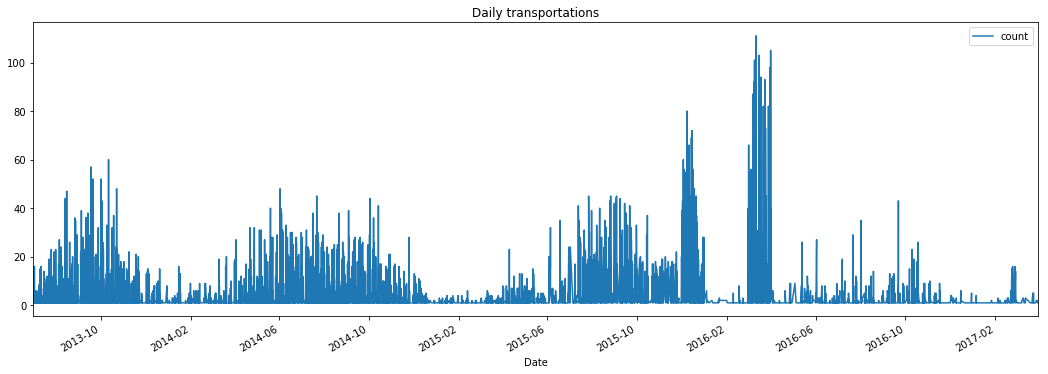

In [6]:
df_519.plot(title='Daily transportations')
None

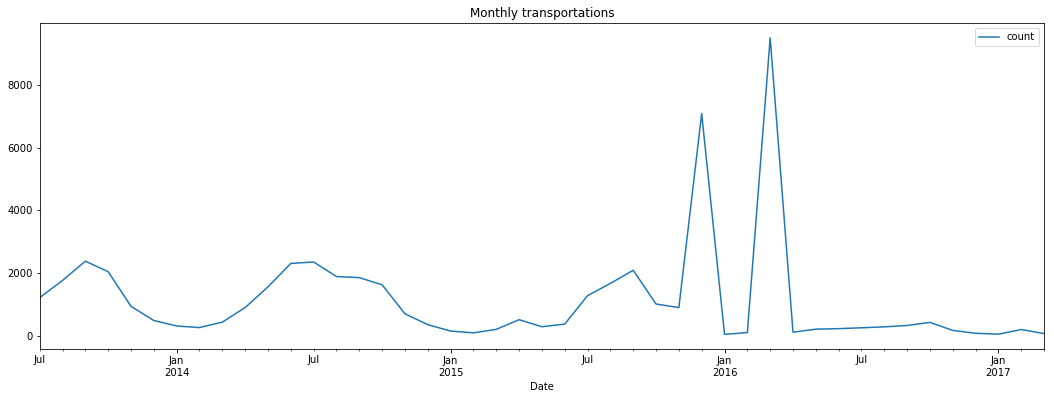

In [7]:
df_519.resample('M').sum().plot(title='Monthly transportations')
None

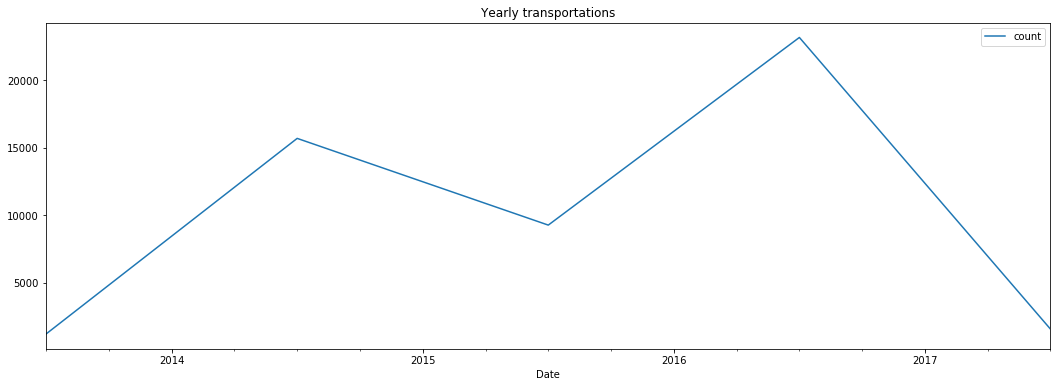

In [8]:
df_519.resample('12M').sum().plot(title='Yearly transportations')
None

In [9]:
# change the frequency to include hours that are missing
converted = df_519.asfreq('60Min', fill_value=0)
converted.head(10)

,count
Date,
2013-07-01 07:00:00,1
2013-07-01 08:00:00,1
2013-07-01 09:00:00,4
2013-07-01 10:00:00,1
2013-07-01 11:00:00,0
2013-07-01 12:00:00,1
2013-07-01 13:00:00,1
2013-07-01 14:00:00,0
2013-07-01 15:00:00,0


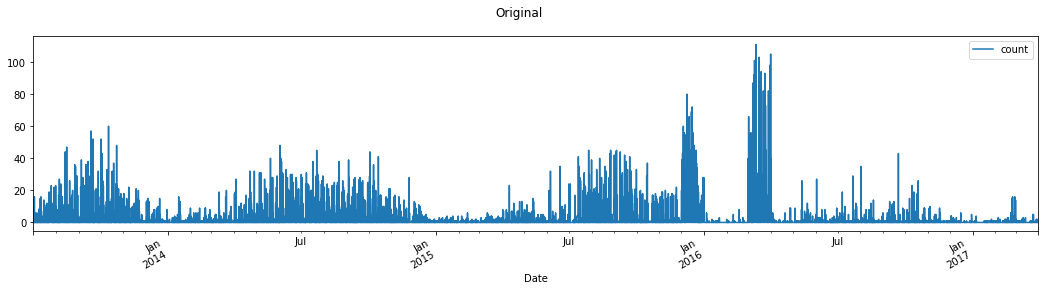

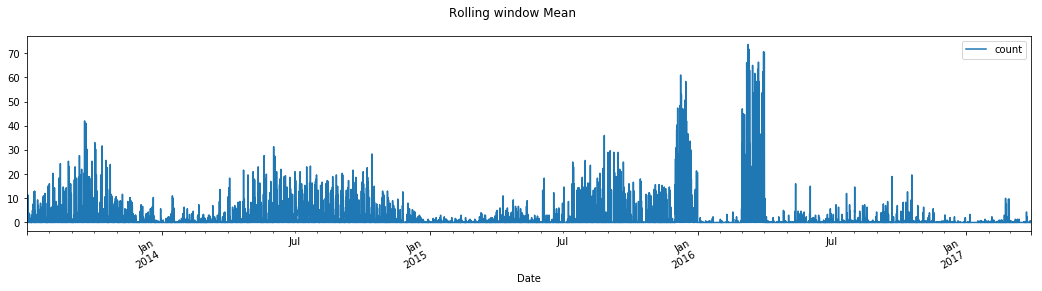

In [10]:
r = converted.rolling(window=3)
converted.plot(subplots=True, figsize=(18, 4), title='Original')
r.mean().plot(subplots=True, figsize=(18, 4), title='Rolling window Mean')
None

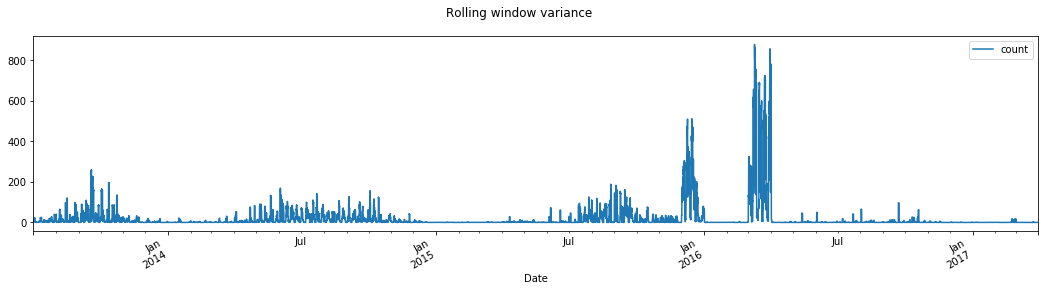

In [11]:
r = converted.rolling(window=20)
r.var().plot(subplots=True, figsize=(18, 4), title='Rolling window variance')
None

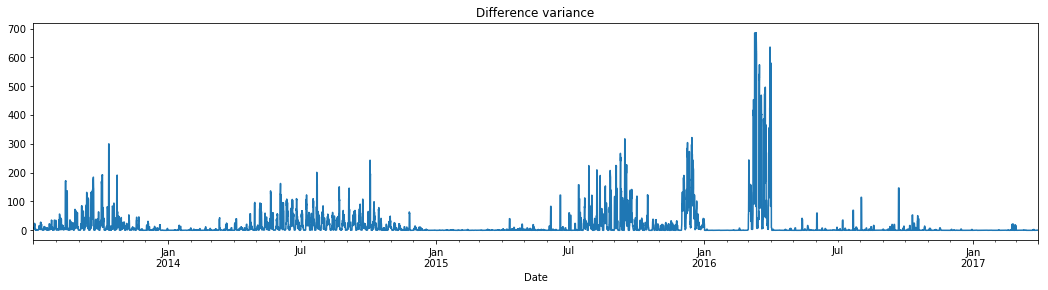

In [12]:
actual = converted['count']
lag = converted['count'].shift()
diff = actual-lag
diff.rolling(window=20).var().plot( figsize=(18, 4), title='Difference variance')
None

In [13]:
pd.DataFrame({'actual':converted['count'],'lag':converted['count'].shift()}).corr()

,actual,lag
actual,1.000000,0.685046
lag,0.685046,1.000000


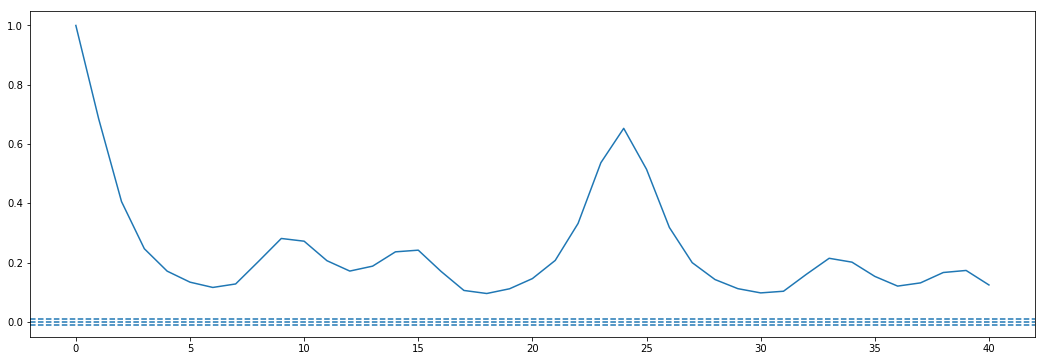

In [14]:
acf_result = stattools.acf(converted)
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(converted)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(converted)),linestyle='--')
None

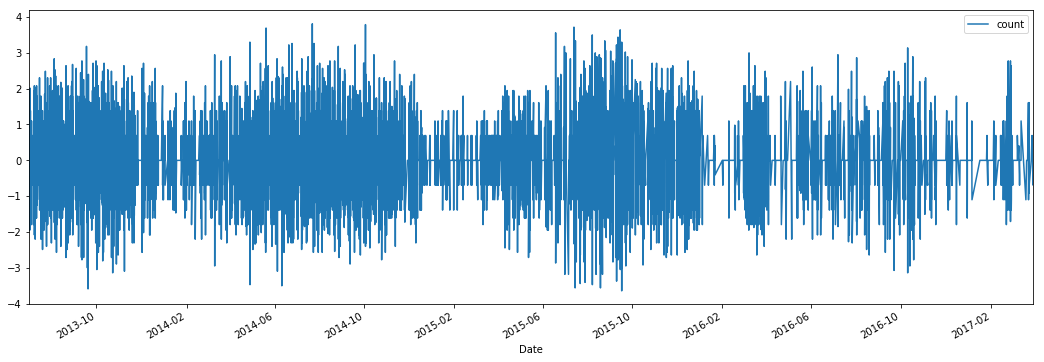

In [15]:
log_converted = np.log(converted[converted['count'] != 0])
log_converted_diff = log_converted - log_converted.shift()
log_converted_diff.dropna(inplace=True)
log_converted_diff.plot()
None

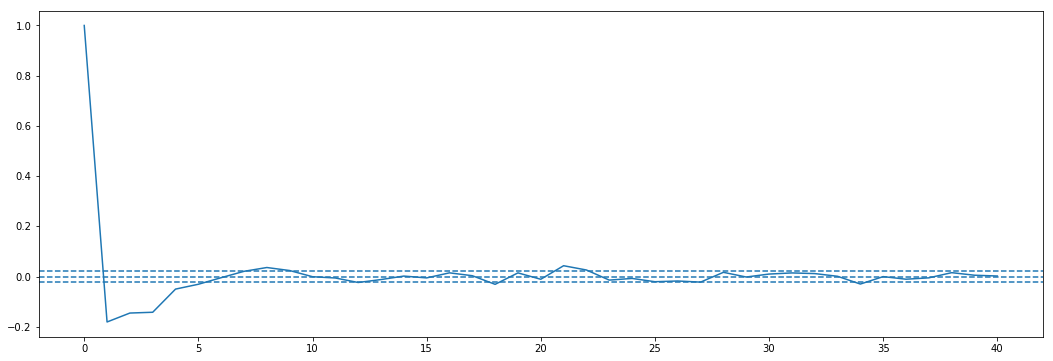

In [16]:
acf_result = stattools.acf(log_converted_diff['count'])
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_converted_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_converted_diff)),linestyle='--')
None

In [17]:
dftest = adfuller(converted['count'], autolag = 'AIC')
pd.Series(dftest[0:5], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Critical values'])

Test Statistic                                                          -12.5803
p-value                                                              1.91717e-23
#Lags Used                                                                    51
Number of Observations Used                                                32787
Critical values                {'1%': -3.43054946357, '5%': -2.86162815778, '...
dtype: object

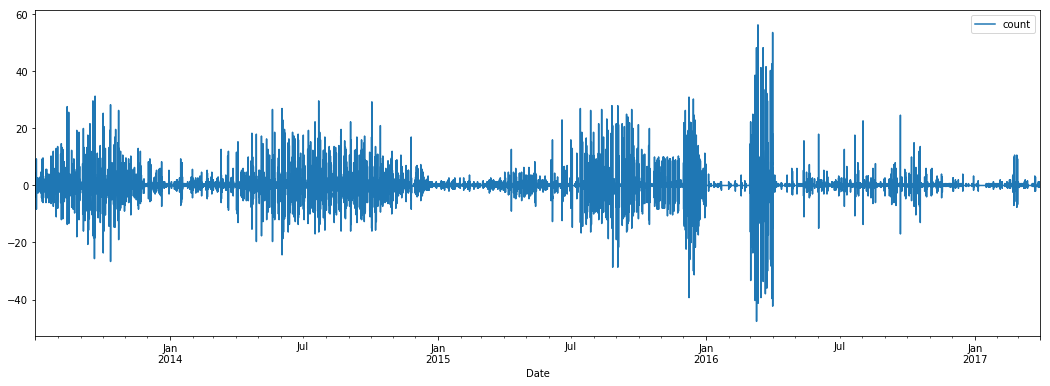

In [18]:
rolling_mean = converted.rolling(window = 3).mean()
count_detrended = converted - rolling_mean
count_detrended.plot()
None

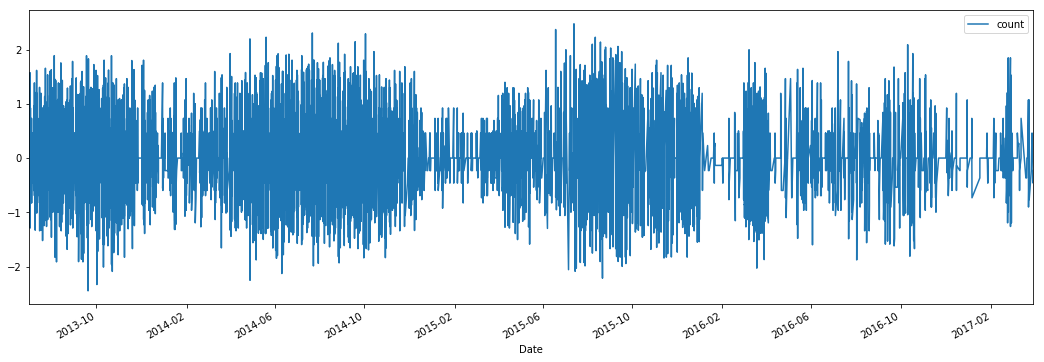

In [19]:
log_rolling_mean = np.log(converted[converted['count'] != 0]).rolling(window = 3).mean()
log_count_detrended = np.log(converted[converted['count'] != 0]) - log_rolling_mean
log_count_detrended.plot()
None

[ 0.00122134]


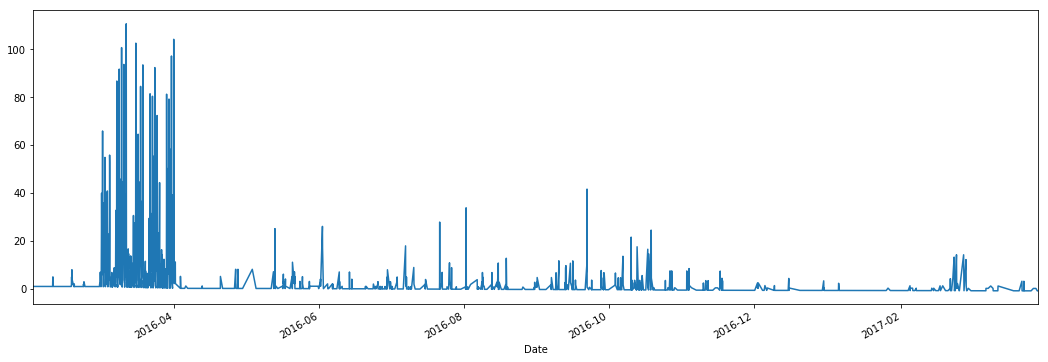

In [20]:
from statsmodels.regression.linear_model import OLS
model = OLS(df_519[:'2016-01-31']['count'].values, list(range(len(df_519[:'2016-01-31']['count'].values))))
result = model.fit()
print(result.params)
fit = pd.Series(result.predict(list(range(len(df_519['2016-02-01':]['count'].values)))), index = df_519['2016-02-01':]['count'].index)

count_detrended = df_519['2016-02-01':]['count'] - fit
count_detrended.plot()

None

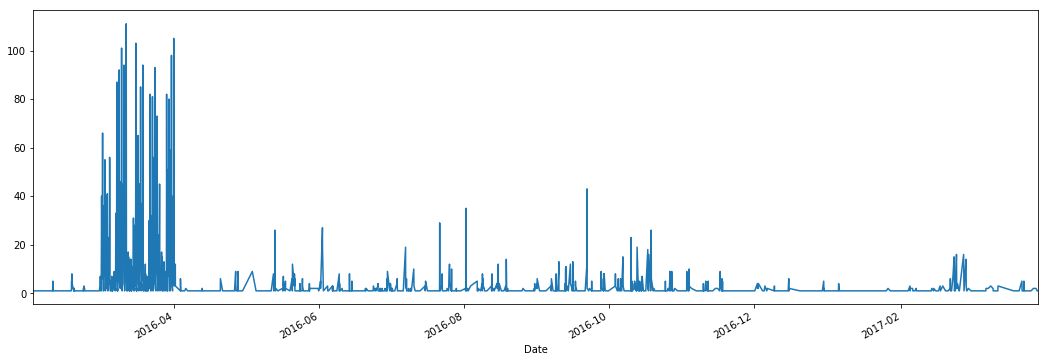

In [21]:
df_519['2016-02-01':]['count'].plot()
None

Date
2013-07-01 07:00:00    0.000000
2013-07-01 08:00:00    0.000000
2013-07-01 09:00:00    1.386294
2013-07-01 10:00:00    0.000000
2013-07-01 11:00:00    0.000000
Freq: 60T, Name: count, dtype: float64

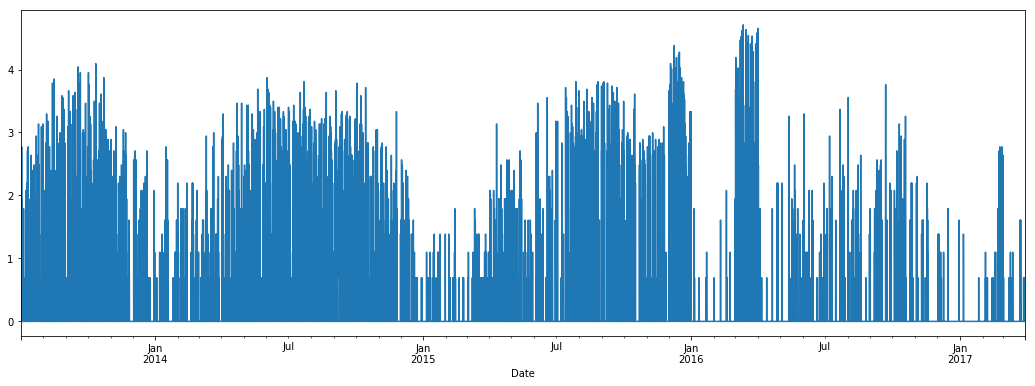

In [22]:
log_count = df_519['count'].apply(lambda x: np.log(x))
log_count = log_count.asfreq('60Min', fill_value=0)
log_count.plot()
None
log_count.head()

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

log_count.interpolate(inplace = True)
decomposition = seasonal_decompose(log_count)

In [24]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

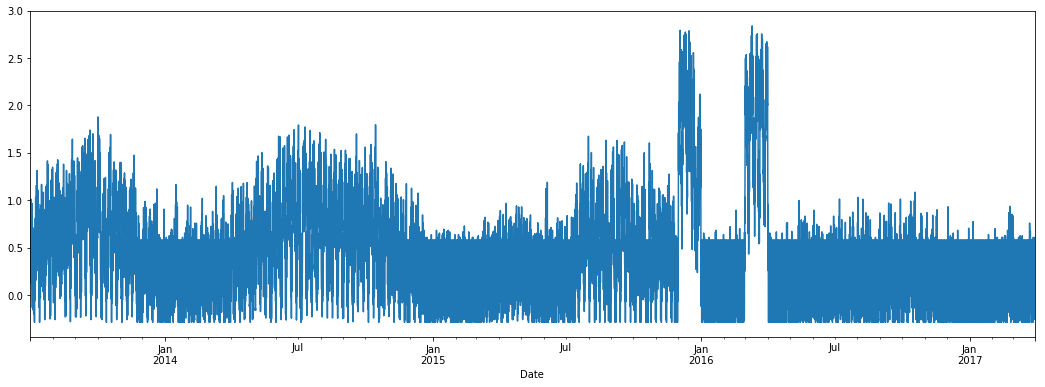

In [25]:
(seasonal+trend).plot()

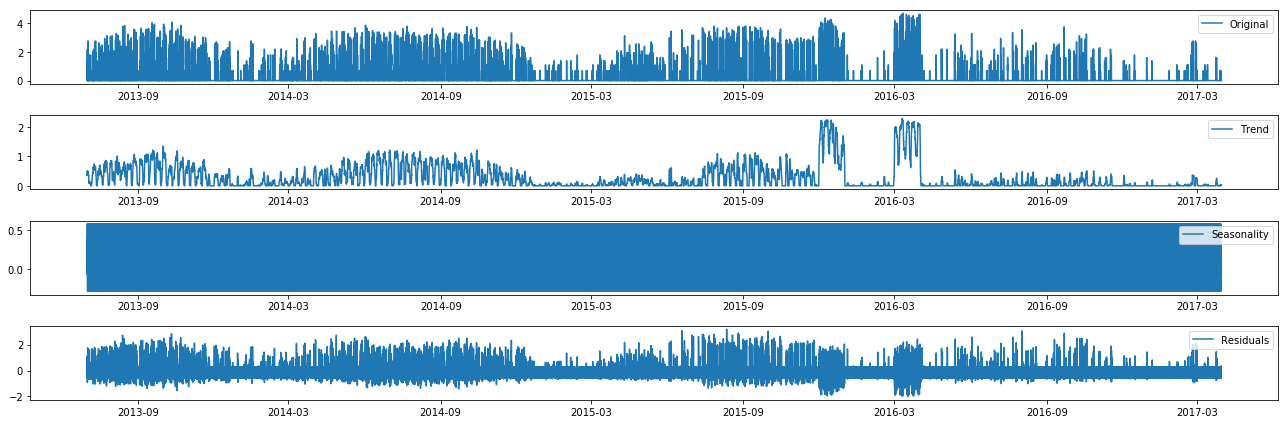

In [26]:
plt.subplot(411)
plt.plot(log_count, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## ARIMA

Date
2013-07-01 08:00:00    0.000000
2013-07-01 09:00:00    1.386294
2013-07-01 10:00:00   -1.386294
2013-07-01 11:00:00    0.000000
2013-07-01 12:00:00    0.000000
Freq: 60T, Name: count, dtype: float64

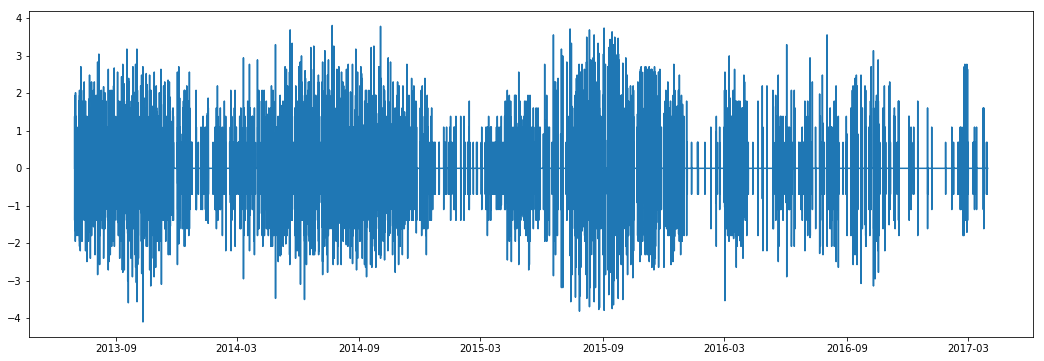

In [27]:
log_count_diff = log_count - log_count.shift()
log_count_diff.dropna(inplace=True)
plt.plot(log_count_diff)
None
log_count_diff.head()

In [28]:
log_lag_acf = acf(log_count_diff.values, nlags = 36)
log_lag_pacf = pacf(log_count_diff.values, nlags = 36)

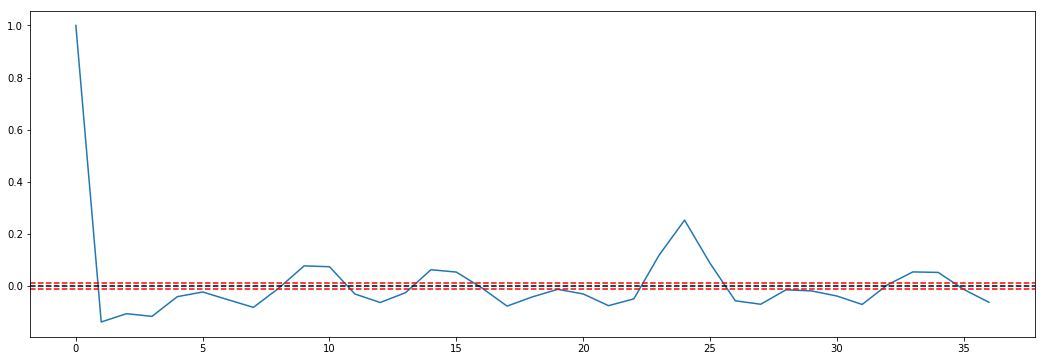

In [29]:
plt.plot(log_lag_acf)
plt.axhline(y=0,linestyle='--', color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(log_count_diff)),linestyle='--', color = 'red')
plt.axhline(y=1.96/np.sqrt(len(log_count_diff)),linestyle='--', color = 'red')
None

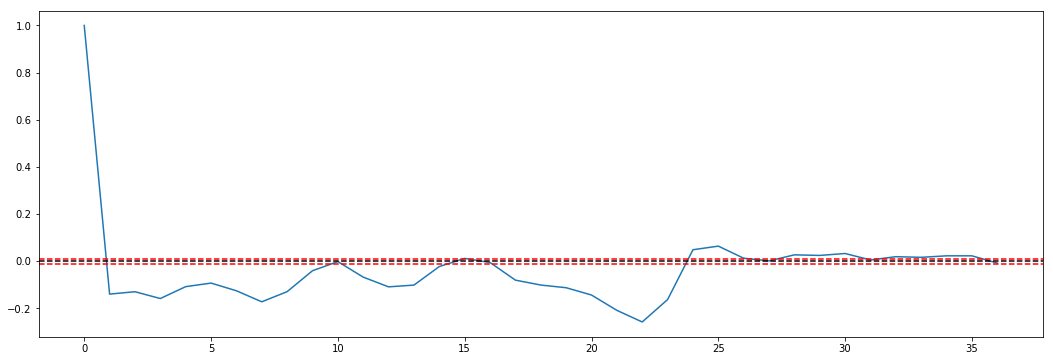

In [30]:
plt.plot(log_lag_pacf)
plt.axhline(y=0,linestyle='--', color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(log_count_diff)),linestyle='--', color = 'red')
plt.axhline(y=1.96/np.sqrt(len(log_count_diff)),linestyle='--', color = 'red')
None

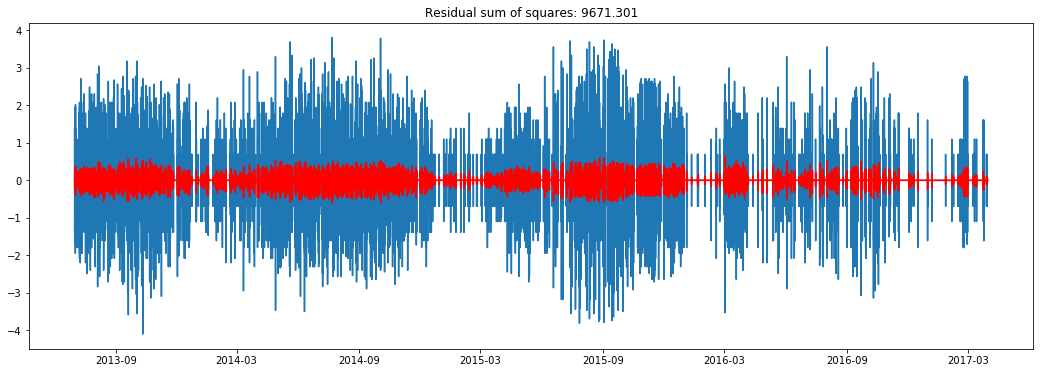

In [31]:
# AR model on differenced data
model = ARIMA(log_count, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_count_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_AR.fittedvalues-log_count_diff)**2))
None

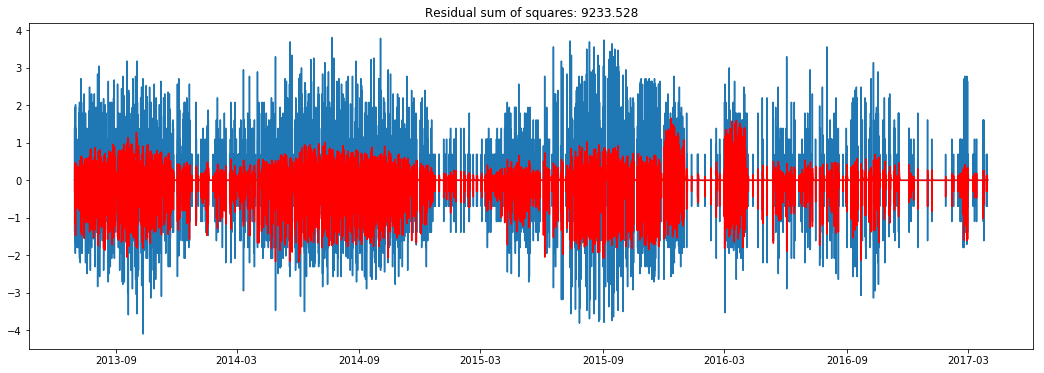

In [32]:
# MA model on differenced data
model = ARIMA(log_count, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_count_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_MA.fittedvalues-log_count_diff)**2))
None

C:\Users\Naveen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


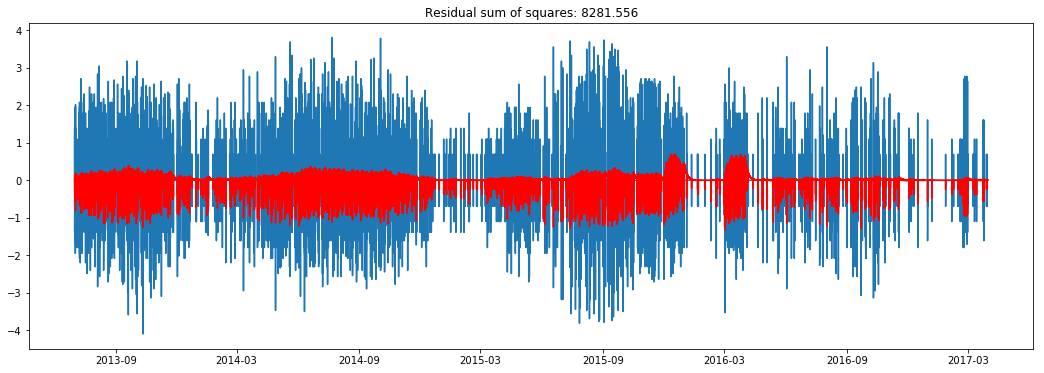

In [33]:
model = ARIMA(log_count, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_count_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_ARIMA.fittedvalues-log_count_diff)**2))
None

In [34]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)

In [35]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()

In [36]:
predictions_ARIMA_log = pd.Series(log_count.iloc[0], index=log_count.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_MA_log = pd.Series(log_count.iloc[0], index=log_count.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)


predictions_AR_log = pd.Series(log_count.iloc[0], index=log_count.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)

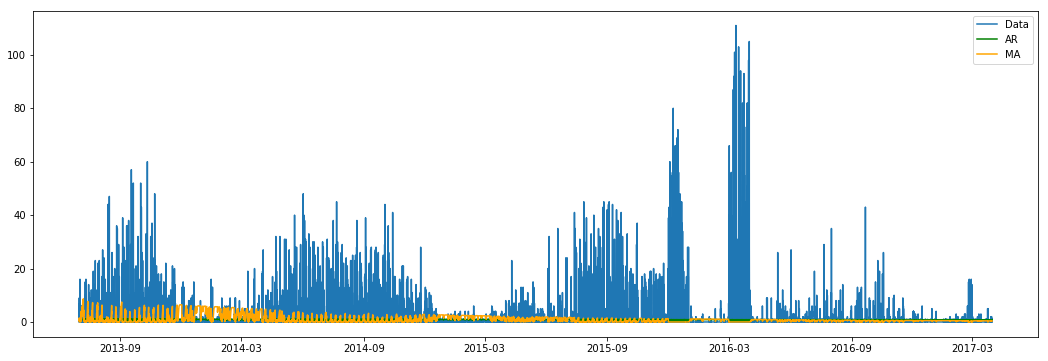

In [37]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_AR = np.exp(predictions_AR_log)
predictions_MA = np.exp(predictions_MA_log)
air1, = plt.plot(converted)
ar, = plt.plot(predictions_AR, color = 'green')
ma, = plt.plot(predictions_MA, color = 'orange')
plt.legend([air1, ar, ma], ['Data', 'AR', 'MA'])

## Spectral Analysis

In [38]:
from numpy import fft
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 5                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

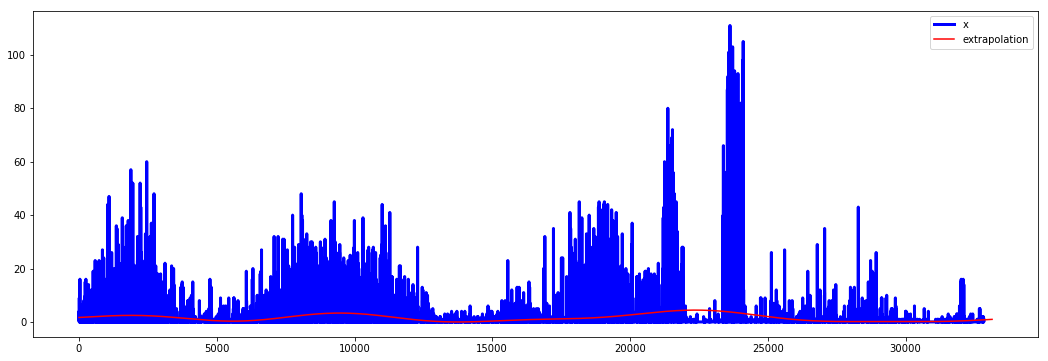

In [39]:
x = np.array(converted['count'].values)
n_predict = 300
extrapolation = fourierExtrapolation(x, n_predict)
plt.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
plt.legend()